In [1]:
#!/usr/bin/env python3

import sys, getopt
import numpy as np
from math import *
import os
import subprocess
import shlex
import regex as re
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from collections import Counter

%matplotlib widget

def intersection_element(sets, threshold = 0.95):		
    c = Counter()
    for s in sets:
        for elem in s:
            c[elem] += 1
    return [k for k, v in c.items() if v >= len(sets) * threshold]

def sort_lists(A, B, k = 3):
	# Create a list of tuples where each tuple contains an element from A and its index in B
	zipped = list(zip(A, B, range(len(B))))

	# Sort the list of tuples based on the values in B
	zipped.sort(key=lambda x: x[1])

	# Create two separate lists from the sorted list of tuples
	sorted_A = [x[0] for x in zipped]
	indices = [x[2] for x in zipped]

	return sorted_A[:k]

def sort_lists_eps(A, B, eps = 0.7):
	# Create a list of tuples where each tuple contains an element from A and its index in B
	zipped = list(zip(A, B, range(len(B))))

	# Sort the list of tuples based on the values in B
	zipped.sort(key=lambda x: x[1])

	t_best = zipped[0][1]
	t_worst = zipped[-1][1]

	threshold = t_best + eps*(t_worst - t_best)

	# Create two separate lists from the sorted list of tuples
	sorted_A = [x[0] for x in zipped if x[1] if x[1] <= threshold]
	sorted_B = [(x[1] - t_best)/(t_worst - t_best) for x in zipped if x[1]]

	return sorted_A, sorted_B

def match_pattern(pattern, line):
	m = []
	matches = re.findall(pattern, line)
	for match in matches:
		m.append(float(match[2:]))
	return m

def average_columns(data):
    # Transpose the 2D list to get the columns as rows
    transposed_data = [[row[i] for row in data] for i in range(len(data[0]))]

    # Calculate the sum of each column and divide by the number of rows
    result = [sum(column) / len(data) for column in transposed_data]

    return result

def intersection_confidence(final_m_values, final_time_values, k_values, threshold_values, k_method = True):
	for k in k_values:
		final_set = set()
		for c in range(len(final_m_values)):
			if k_method:
				final_m = sort_lists(final_m_values[c], final_time_values[c], k)
			else:
				final_m = sort_lists_eps(final_m_values[c], final_time_values[c], k)[0]
			if c == len(final_m_values) - 1:
				print("Final m values for square:", final_m)
			final_set.add(frozenset(final_m))

		for l in threshold_values:
			values = intersection_element(final_set, l)
			if len(values) != 0:
				if k_method:
					print("Common intersection of m values with threshold " + str(l) + " and k values " + str(k), values)
				else:
					print("Common intersection of m values with threshold " + str(l) + " and eps values " + str(k), values)
					
def optimal_values(final_m_values, final_time_values, point_to_compare = 0):
	final_set = []
	for c in range(len(final_m_values)):
		final_m = sort_lists(final_m_values[c], final_time_values[c], 1)[0]
		final_set.append(final_m - point_to_compare)
	return final_set

def shared_factors(num1, num2):
    # Find the smaller of the two numbers
    if num1 < num2:
        smaller = num1
    else:
        smaller = num2

    # Initialize a variable to keep track of the number of shared factors
    shared = 0

    # Check each number from 1 to the smaller number
    for i in range(1, smaller + 1):
        # If i is a factor of both num1 and num2, increment the shared variable
        if num1 % i == 0 and num2 % i == 0:
            shared += 1

    # Return the number of shared factors
    return shared


def plot2d(x,y,thread, threshold, point_to_compare):
	plt.title("Common intersection with threshold {} and point {}".format(threshold, point_to_compare))
	plt.xlabel("Ly values")
	plt.ylabel("Difference between the optimal value and the point to compare")
	plt.plot(x, y, label = "Thread " + str(thread))
	plt.savefig("threshold_" + str(threshold) + "_point_" + str(point_to_compare) + ".png")
	plt.show()

def plot(x,y,z,thread, plot_type = "3d"):
	# Create the figure and 3D axis
	fig = plt.figure(figsize = (10,10))
	if plot_type == "3d":
		ax = fig.add_subplot(111, projection='3d')
	else:
		ax = fig.add_subplot(111)

	# Plot the data
	colors = ['r', 'g', 'b', 'y', 'c', 'm', 'k', 'w'][:len(x)]

	optimal_t = []
	optimal_y = []
	for i in range(len(x)):
		max_time = float(1e5)
		max_m = 0
		for j in range(len(y[i])):
			if max_time > z[i][j]:
				max_m = y[i][j]
				max_time = z[i][j]
		optimal_t.append(max_time)
		optimal_y.append(max_m)
		
	print("Max upper bound on time:", max(optimal_t),"\n")
	print("Min upper bound on time:", min(optimal_t),"\n")
	print("Average upper bound on time:", sum(optimal_t)/len(optimal_t),"\n")

	print("Max m value:", max(optimal_y),"\n")
	print("Min m value:", min(optimal_y),"\n")
	print("Average m value:", sum(optimal_y)/len(optimal_y),"\n")

	if plot_type == "3d":
	
		for i in range(len(x)):
			ax.scatter(x[i], y[i], z[i], c=colors[i%8], marker='o')
			ax.text(x[i], optimal_y[i], optimal_t[i], "OP", size=10, zorder=1, color='k')
	
		#cb = plt.colorbar(ax1, pad=0.2)

		# Set axis labels
		ax.set_title('Time taken vs Ly and m values')
		#ax.set_xticks(x)
		ax.set_ylabel('m values')
		ax.set_zlabel('time taken values')
		ax.set_xlabel('Ly values')
	else:
		plt.scatter(x, optimal_y)
		plt.title('Optimal m values vs Ly values')
		plt.ylabel('m values')
		plt.xlabel('Ly values')
		#plt.yticks(optimal_y)

	# Show the plot
	#plt.savefig("test.png")
	plt.show()

# Main Results

In [11]:
thread = [[],[],[],[],[],[],[],[]]
lx_values = [j for j in [64,128,256,512,1024]]
final_m_values = []
final_time_values = []
t_array = [1]
random_averages = 5

for l in lx_values:
	print("Lx=", l, end="\n")
	for thread in t_array:
		final_m_values = []
		final_time_values = []
		final_set = set()
		ly_values = [i for i in range(2, l)]
		for i in ly_values:
			print("Thread ", thread, ": ", end=" ")
			print("Ly=", i, end="\n")
			averaged_columns_m = []
			averaged_columns_time = []
			for k in range(random_averages):
				string = "./hybridconv2 -Lx=" + str(l) + "-Ly=" + str(i) + " -Mx=" + str(2*l) +" -My=" + str(2*i) + " -t -R -T=" + str(thread)
				cmd = subprocess.run(shlex.split(string), capture_output=True, text=True)
				string = cmd.stdout

				pattern = "m="
				matches = re.finditer(pattern, string)
				for match in matches:
					# Get the starting index of the match

					start = match.start()
					if int(start) < 100:
						# Get the line number by counting the number of newline characters before the match

						line_num = string[:start].count("\n") + 1
						line_start = string.rfind("\n", 0, start) + 1
						line_end = string.find("Optimal time: ", start)
						line = string[line_start:line_end]
						# Extract the values as a float and append to a list
						m_values = match_pattern("m=\d+", line)
						time_values = match_pattern("t=\d+\.\d+", line)

				averaged_columns_m.append(m_values[:9])
				averaged_columns_time.append(time_values[:9])
			print(len(averaged_columns_m[0]), len(averaged_columns_m[1]), len(averaged_columns_m[2]), len(averaged_columns_m[3]), len(averaged_columns_m[4]))
			print(len(averaged_columns_time[0]), len(averaged_columns_time[1]), len(averaged_columns_time[2]), len(averaged_columns_time[3]), len(averaged_columns_time[4]))
			final_m_values.append(average_columns(averaged_columns_m)[:9])
			final_time_values.append(average_columns(averaged_columns_time)[:9])
		print("-------------------------------------------------------")
		#plot(ly_values,final_m_values,final_time_values,thread)
		final_m_values = np.array(final_m_values)
		final_time_values = np.array(final_time_values)
		np.save("final_square_m_values" + str(l), final_m_values)
		np.save("final_square_time_values" + str(l), final_time_values)

Lx= 64
Thread  1 :  Ly= 2
9 9 9 9 9
9 9 9 9 9
Thread  1 :  Ly= 3
9 9 9 9 9
9 9 9 9 9
Thread  1 :  Ly= 4
9 9 9 9 9
9 9 9 9 9
Thread  1 :  Ly= 5
9 9 9 9 9
9 9 9 9 9
Thread  1 :  Ly= 6
9 9 9 9 9
9 9 9 9 9
Thread  1 :  Ly= 7
9 9 9 9 9
9 9 9 9 9
Thread  1 :  Ly= 8
9 9 9 9 9
9 9 9 9 9
Thread  1 :  Ly= 9
9 9 9 9 9
9 9 9 9 9
Thread  1 :  Ly= 10
9 9 9 9 9
9 9 9 9 9
Thread  1 :  Ly= 11
9 9 9 9 9
9 9 9 9 9
Thread  1 :  Ly= 12
9 9 9 9 9
9 9 9 9 9
Thread  1 :  Ly= 13
9 9 9 9 9
9 9 9 9 9
Thread  1 :  Ly= 14
9 9 9 9 9
9 9 9 9 9
Thread  1 :  Ly= 15
9 9 9 9 9
9 9 9 9 9
Thread  1 :  Ly= 16
9 9 9 9 9
9 9 9 9 9
Thread  1 :  Ly= 17
9 9 9 9 9
9 9 9 9 9
Thread  1 :  Ly= 18
9 9 9 9 9
9 9 9 9 9
Thread  1 :  Ly= 19
9 9 9 9 9
9 9 9 9 9
Thread  1 :  Ly= 20
9 9 9 9 9
9 9 9 9 9
Thread  1 :  Ly= 21
9 9 9 9 9
9 9 9 9 9
Thread  1 :  Ly= 22
9 9 9 9 9
9 9 9 9 9
Thread  1 :  Ly= 23
9 9 9 9 9
9 9 9 9 9
Thread  1 :  Ly= 24
9 9 9 9 9
9 9 9 9 9
Thread  1 :  Ly= 25
9 9 9 9 9
9 9 9 9 9
Thread  1 :  Ly= 26
9 9 9 9 9
9 9 9 9 9
T

In [ ]:
final_m_values = np.load("final_m_values.npy")
final_time_values = np.load("final_time_values.npy")

# Best m values and how often they appear
z = optimal_values(final_m_values, final_time_values, 0)
r = Counter(z)

print("Optimal values for m:", r)

# Plot Ly_values vs m_values against the optimal 2d square
ly_values = [i for i in range(2,513)]
#plot(ly_values,final_m_values,final_time_values,thread,"2d")

plot(ly_values[400:], final_m_values[400:], final_time_values, thread=1, plot_type="2d")

# Final statistics
print("Final statistics:")

# final statistics for k = 3,5,7
#intersection_confidence(final_m_values, final_time_values, [3,5,7], [0.1,0.2,0.3,0.4,0.5,0.6,0.8,0.9], True)

# final statistcis for eps = 0.1,0.5,1
intersection_confidence(final_m_values, final_time_values, [0.1,0.2,0.5,0.6,0.9], [0.1,0.2,0.3,0.4,0.5,0.6,0.8,0.9], False)

In [ ]:
for i in [2,4,8,16,32,64,128,256]:
	print("Ly value = ", i)
	m, time = sort_lists_eps(final_m_values[i-1], final_time_values[i-1], 0.1)
	print("m values: ", m)
	print("time values: ", time)
	print("\n")

# Square optimal Values

In [18]:
final_square_m = np.load("final_square_m_values.npy")
final_square_time = np.load("final_square_time_values.npy")
final_square_m

array([[1.600e+01, 8.000e+00, 2.700e+01, 2.500e+01, 1.600e+01, 9.000e+00,
        8.000e+00, 7.000e+00, 5.000e+00, 4.000e+00],
       [3.200e+01, 1.600e+01, 2.700e+01, 2.500e+01, 1.600e+01, 9.000e+00,
        8.000e+00, 7.000e+00, 5.000e+00, 4.000e+00],
       [1.280e+02, 6.400e+01, 3.200e+01, 2.700e+01, 2.500e+01, 1.600e+01,
        9.000e+00, 8.000e+00, 4.000e+00, 2.000e+00],
       [2.560e+02, 1.280e+02, 6.400e+01, 4.900e+01, 3.200e+01, 2.700e+01,
        1.600e+01, 8.000e+00, 4.000e+00, 2.000e+00],
       [5.120e+02, 2.560e+02, 1.280e+02, 1.250e+02, 8.100e+01, 6.400e+01,
        3.200e+01, 1.600e+01, 8.000e+00, 4.000e+00],
       [1.024e+03, 5.120e+02, 2.560e+02, 2.430e+02, 1.280e+02, 1.250e+02,
        8.100e+01, 6.400e+01, 3.200e+01, 1.600e+01],
       [2.048e+03, 1.024e+03, 5.120e+02, 3.430e+02, 2.560e+02, 2.430e+02,
        1.280e+02, 1.250e+02, 6.400e+01, 3.200e+01]])

In [7]:
def square_optimal(square_size, threshold, epsilon):
    array3 = []
    for a in range(len(epsilon)):
        print("Epsilon = ", epsilon[a])
        print("******************************************************", end="\n")
        array2 = []
        for i in range(len(square_size)):
            print("Square size = ", square_size[i])
            final_square_m = np.load("final_square_m_values" + str(square_size[i]) + ".npy").tolist()
            final_square_time = np.load("final_square_time_values" + str(square_size[i]) + ".npy").tolist()
            final_best_square_m = np.load("final_square_m_values.npy")
            final_best_square_time = np.load("final_square_time_values.npy")
            best_m = sort_lists(final_best_square_m[i], final_best_square_time[i], 1)[0]
            array1 = []
            for j in range(2,square_size[i]):
                if shared_factors(j, square_size[i]) > threshold:
                    m = sort_lists_eps(final_square_m[j-1], final_square_time[j-1], epsilon[a])[0]
                    if best_m in m:
                        print("Ly value = ", j)
                        array1.append(j)
            if len(array1) == 0:
                print("No Ly values found.")
                array1.append(0)
            array2.append(array1)
            print("------------------------------------------------------")
        array3.append(array2)
    return array3

epsilon = [0.1,0.2,0.3,0.5,0.6,0.7,0.8,1]
square_size = [16,32,64,128,256,512,1024]
threshold = 5
array3 = square_optimal(square_size, threshold, epsilon)

Epsilon =  0.1
******************************************************
Square size =  16
No Ly values found.
------------------------------------------------------
Square size =  32
No Ly values found.
------------------------------------------------------
Square size =  64
No Ly values found.
------------------------------------------------------
Square size =  128
Ly value =  32
Ly value =  64
Ly value =  96
------------------------------------------------------
Square size =  256
Ly value =  32
Ly value =  64
Ly value =  96
Ly value =  128
Ly value =  160
Ly value =  192
Ly value =  224
------------------------------------------------------
Square size =  512
Ly value =  32
Ly value =  64
Ly value =  96
Ly value =  128
Ly value =  160
Ly value =  192
Ly value =  224
Ly value =  256
Ly value =  288
Ly value =  320
Ly value =  352
Ly value =  384
Ly value =  416
Ly value =  448
Ly value =  480
------------------------------------------------------
Square size =  1024
Ly value =  32
Ly 

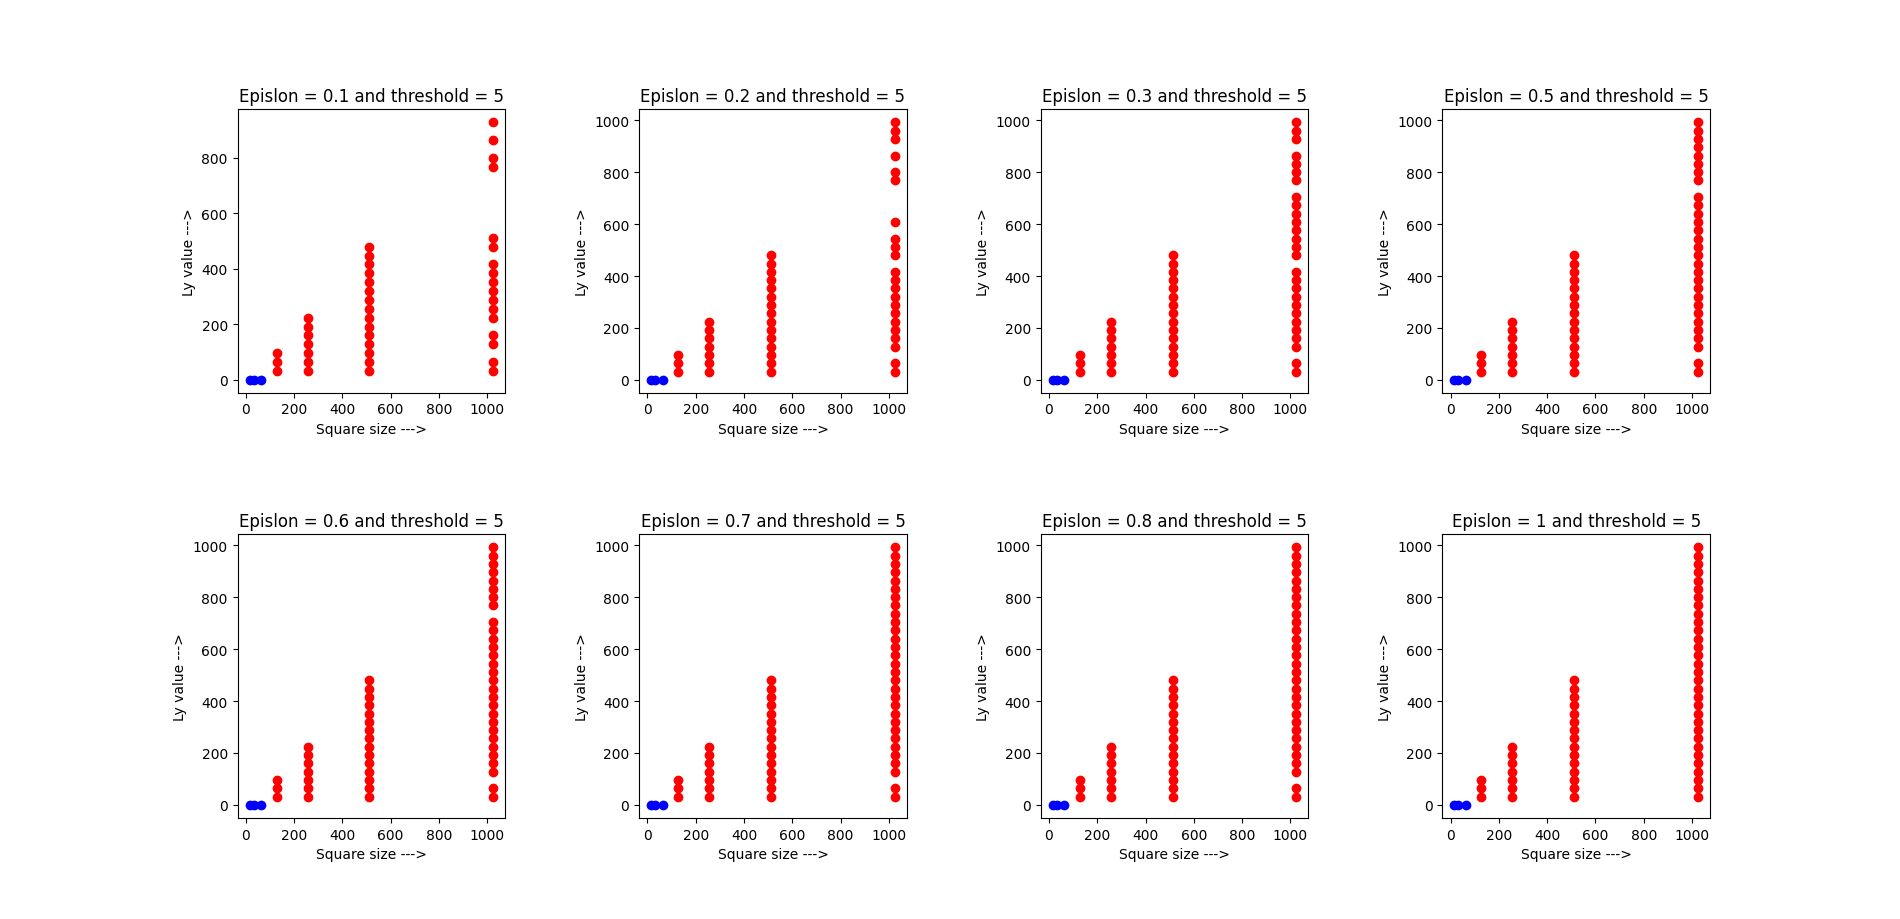

In [19]:
y = array3
x = square_size

fig, axs = plt.subplots(2, 4, figsize=(19, 9.2), gridspec_kw={'wspace': 0.5, 'hspace': 0.5})
r = 0
for j in range(len(epsilon)):
    if j == 4:
        r = 1
    for i in range(len(square_size)):
        if y[j][i] == [0]:
            axs[r][j%4].scatter([x[i]]*len(y[j][i]), y[j][i], color = 'blue')
        else:
            axs[r][j%4].scatter([x[i]]*len(y[j][i]), y[j][i], label = "Epsilon = " + str(epsilon[j]), color = 'red')

    axs[r][j%4].set_xlabel('Square size --->')
    axs[r][j%4].set_ylabel('Ly value --->')
    axs[r][j%4].set_title('Epislon = ' + str(epsilon[j]) + ' and threshold = ' + str(threshold))

plt.show()

In [ ]:
# plot by plot
y = array3
x = square_size

r = 0
for j in range(len(epsilon)):
	for i in range(len(square_size)):
		if y[j][i] == [0]:
			plt.scatter([x[i]]*len(y[j][i]), y[j][i], color = 'blue')
		else:
			plt.scatter([x[i]]*len(y[j][i]), y[j][i], label = "Epsilon = " + str(epsilon[j]), color = 'red')

	plt.xlabel('Square size --->')
	plt.ylabel('Ly value --->')
	plt.title('Epislon = ' + str(epsilon[j]) + ' and threshold = 7')

plt.show()

# Machine Learning

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV

from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor

from sklearn.tree import DecisionTreeRegressor
import lazypredict
from lazypredict.Supervised import LazyRegressor


from sklearn.multioutput import MultiOutputRegressor

In [2]:
# Prepare the data
final_data = []
square_size = [16,32,64,128,256,512,1024]
for i in square_size:
	ly_values = [b for b in range(2,i)]
	final_m_values = np.load("final_square_m_values" + str(i) + ".npy").tolist()
	final_time_values = np.load("final_square_time_values" + str(i) + ".npy").tolist()
	for m in range(len(ly_values)):
		for n in range(len(final_m_values[m])):	
			final_data.append([ly_values[m], ly_values[m]*2, i, 2*i, final_m_values[m][n], final_time_values[m][n]])

final_data = np.array(final_data)
dataset = pd.DataFrame({'Ly': final_data[:, 0], 'My': final_data[:, 1], 'Lx': final_data[:, 2], 'Mx': final_data[:, 3], 'm': final_data[:, 4], 'time': final_data[:, 5]})


In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18206 entries, 0 to 18205
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Ly      18206 non-null  float64
 1   My      18206 non-null  float64
 2   Lx      18206 non-null  float64
 3   Mx      18206 non-null  float64
 4   m       18206 non-null  float64
 5   time    18206 non-null  float64
dtypes: float64(6)
memory usage: 853.5 KB


In [4]:
# ML part
X = dataset.drop(['m','time'], axis=1)
y = dataset[['m']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

reg = LazyRegressor(verbose=10, ignore_warnings=False, custom_metric=None)
models, predictions = reg.fit(X_train, X_test, y_train, y_test)

  0%|          | 0/42 [00:00<?, ?it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': -0.07047439950438639, 'Adjusted R-Squared': -0.07125906096636503, 'RMSE': 497.6244220616659, 'Time taken': 0.08810806274414062}


 17%|█▋        | 7/42 [00:00<00:01, 17.96it/s]

{'Model': 'BaggingRegressor', 'R-Squared': -0.16242769930649925, 'Adjusted R-Squared': -0.16327976285739276, 'RMSE': 518.5570206809454, 'Time taken': 0.21797561645507812}
{'Model': 'BayesianRidge', 'R-Squared': 0.13921194902139966, 'Adjusted R-Squared': 0.13858098838296928, 'RMSE': 446.2329733116845, 'Time taken': 0.011547565460205078}
{'Model': 'DecisionTreeRegressor', 'R-Squared': -0.15312922465779932, 'Adjusted R-Squared': -0.15397447239440032, 'RMSE': 516.4788395301615, 'Time taken': 0.033585309982299805}
{'Model': 'DummyRegressor', 'R-Squared': -0.0005809336994664349, 'Adjusted R-Squared': -0.0013143630076573043, 'RMSE': 481.1047612838856, 'Time taken': 0.008834362030029297}
{'Model': 'ElasticNet', 'R-Squared': 0.13362747170258016, 'Adjusted R-Squared': 0.13299241762283132, 'RMSE': 447.6781311606735, 'Time taken': 0.014925241470336914}
{'Model': 'ElasticNetCV', 'R-Squared': 0.13813393933171692, 'Adjusted R-Squared': 0.13750218850843066, 'RMSE': 446.5123062751406, 'Time taken': 0.0

 24%|██▍       | 10/42 [00:01<00:03,  9.13it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': -0.15312837108708588, 'Adjusted R-Squared': -0.15397361819801647, 'RMSE': 516.4786483758296, 'Time taken': 0.5457413196563721}
{'Model': 'GammaRegressor', 'R-Squared': 0.12231249294149271, 'Adjusted R-Squared': 0.12166914494291581, 'RMSE': 450.592025893686, 'Time taken': 0.009932994842529297}
{'Model': 'GaussianProcessRegressor', 'R-Squared': 0.1359774926785431, 'Adjusted R-Squared': 0.13534416117235182, 'RMSE': 447.0705591563856, 'Time taken': 17.159433126449585}


 36%|███▌      | 15/42 [00:18<00:42,  1.59s/it]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.12053165722554415, 'Adjusted R-Squared': 0.11988700386818707, 'RMSE': 451.0489218529068, 'Time taken': 0.4243967533111572}
{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.11958217073439348, 'Adjusted R-Squared': 0.11893682140013251, 'RMSE': 451.29233557769646, 'Time taken': 0.0765988826751709}
{'Model': 'HuberRegressor', 'R-Squared': 0.013309153172865962, 'Adjusted R-Squared': 0.012585905346714554, 'RMSE': 477.7537373715123, 'Time taken': 0.020268917083740234}
{'Model': 'KNeighborsRegressor', 'R-Squared': -0.16015515316122153, 'Adjusted R-Squared': -0.16100555092787805, 'RMSE': 518.0498832100614, 'Time taken': 0.03404951095581055}


 57%|█████▋    | 24/42 [00:24<00:15,  1.19it/s]

{'Model': 'KernelRidge', 'R-Squared': -0.39631739346006234, 'Adjusted R-Squared': -0.3973408989711198, 'RMSE': 568.3365902405644, 'Time taken': 5.646039009094238}
{'Model': 'Lars', 'R-Squared': 0.13920875891780526, 'Adjusted R-Squared': 0.13857779594101793, 'RMSE': 446.2338001865996, 'Time taken': 0.007716655731201172}
{'Model': 'LarsCV', 'R-Squared': 0.1393467830631302, 'Adjusted R-Squared': 0.13871592125852195, 'RMSE': 446.1980229242924, 'Time taken': 0.01020669937133789}
{'Model': 'Lasso', 'R-Squared': 0.1392796404975657, 'Adjusted R-Squared': 0.13864872947722306, 'RMSE': 446.2154273185031, 'Time taken': 0.005196332931518555}
{'Model': 'LassoCV', 'R-Squared': 0.13938179167701203, 'Adjusted R-Squared': 0.13875095553383965, 'RMSE': 446.1889478794044, 'Time taken': 0.05558419227600098}
{'Model': 'LassoLars', 'R-Squared': 0.13927996717485147, 'Adjusted R-Squared': 0.1386490563939644, 'RMSE': 446.21534264032806, 'Time taken': 0.006276845932006836}
{'Model': 'LassoLarsCV', 'R-Squared': 0.

 67%|██████▋   | 28/42 [00:30<00:14,  1.06s/it]

{'Model': 'NuSVR', 'R-Squared': -0.020213802147039273, 'Adjusted R-Squared': -0.020961622416159287, 'RMSE': 485.80182363741346, 'Time taken': 3.1288247108459473}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.13927008963957888, 'Adjusted R-Squared': 0.1386391716184241, 'RMSE': 446.21790299385367, 'Time taken': 0.006671905517578125}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.13927008963957888, 'Adjusted R-Squared': 0.1386391716184241, 'RMSE': 446.21790299385367, 'Time taken': 0.00915217399597168}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': -0.022508144475032577, 'Adjusted R-Squared': -0.023257646505067342, 'RMSE': 486.34777279984837, 'Time taken': 0.009728670120239258}
{'Model': 'PoissonRegressor', 'R-Squared': 0.13326721073287384, 'Adjusted R-Squared': 0.13263189258057984, 'RMSE': 447.771199782789, 'Time taken': 0.007099151611328125}


 67%|██████▋   | 28/42 [00:50<00:14,  1.06s/it]

# Manual Optimization

In [9]:
# ML part
X = dataset.drop(['m','time'], axis=1)
y = dataset[['m']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=101)

# Prepare a dictionary of estimators after instantiating each one of them
ESTIMATORS = {
    "Extra trees": ExtraTreesRegressor(n_estimators=100,
                                       max_features=5000,     # Out of 20000
                                       random_state=0),
    "K-nn": KNeighborsRegressor(),                          # Accept default parameters
    "Linear regression": LinearRegression(),
    "Ridge": RidgeCV(),
    "Lasso": Lasso(),
    "ElasticNet": ElasticNet(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(max_depth=100, random_state=2),
    "Decision Tree Regressor":DecisionTreeRegressor(max_depth=100),
    "MultiO/P GBR" :MultiOutputRegressor(GradientBoostingRegressor(n_estimators=100)),
    "MultiO/P AdaB" :MultiOutputRegressor(AdaBoostRegressor(n_estimators=100))
}

y_test_predict = dict()
y_mse = dict()

current = -1e5
model = None
for name, estimator in ESTIMATORS.items():     
    estimator.fit(X_train, y_train)                    # fit() with instantiated object
    y_mse[name] = estimator.score(X_test, y_test)
    value = y_mse[name]
    if value > current and value > 0:
        current = y_mse[name]
        best = name
        model = estimator
y_mse

/tmp/ipykernel_358913/2416138286.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train)                    # fit() with instantiated object
/tmp/ipykernel_358913/2416138286.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train)                    # fit() with instantiated object


{'Extra trees': -0.13592928797964232,
 'K-nn': -0.22378623677670517,
 'Linear regression': 0.12583211852590048,
 'Ridge': 0.1258321098871764,
 'Lasso': 0.12583267194532044,
 'ElasticNet': 0.1258323950885788,
 'RandomForestRegressor': -0.14098706969728791,
 'Decision Tree Regressor': -0.13592928797964232,
 'MultiO/P GBR': 0.10199685979475437,
 'MultiO/P AdaB': 0.11224466097712904}

In [10]:
X_test_final = X_test
y = model.predict(X_test)
X_test_final['m_predict'] = y[:] - y_test['m'].astype(int).to_numpy()
X_test_final = X_test_final.astype(int)
#X_test_final['time_predict'] = y[:,1] - y_test['time'].to_numpy()

In [12]:
X_test_final[X_test_final['m_predict'] == 0]

,Ly,My,Lx,Mx,m_predict
292,17,34,32,64,0
